In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d

from dotenv import load_dotenv, find_dotenv
from pathlib import Path

from skimage.measure import label

from src.data.rgbd import load_rgbd

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
project_dir = Path(dotenv_path).parent

# load up the entries as environment variables
load_dotenv(dotenv_path)

True

In [3]:
raw_data_dir = project_dir/'data/raw/render_results_imov_cam_mist_simple'

img_fpath = np.random.choice(list(raw_data_dir.glob('*/*.exr')))

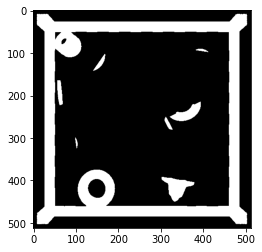

In [19]:
rgbd = load_rgbd(img_fpath, (256,256), 711.1111)

depth = np.asarray(rgbd.depth)

top = (1.5-depth) >= 0.5

plt.imshow(top, cmap='gray')
plt.show()

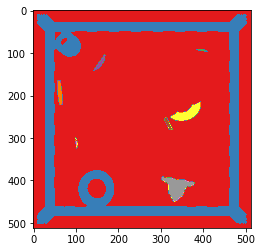

In [23]:
labeled, num = label(top, background=0, return_num=True)

plt.imshow(labeled, cmap='Set1')

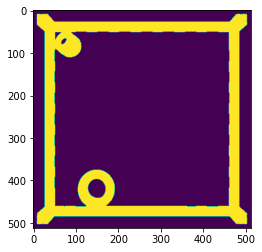

In [27]:
for i in range(1, num+1):
    break

plt.imshow(labeled == i)

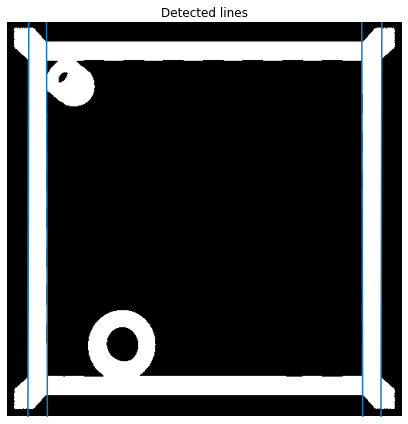

In [59]:
from skimage.feature import canny
from skimage.transform import hough_line, hough_line_peaks
from matplotlib import cm


edges = canny(l, sigma=1)

# Classic straight-line Hough transform
# Set a precision of 0.5 degree.
r = 1/8
tested_angles = np.linspace(-np.pi*r, np.pi*r, 180, endpoint=True)
h, theta, d = hough_line(edges, theta=tested_angles)

angle_step = 0.5 * np.diff(theta).mean()
d_step = 0.5 * np.diff(d).mean()
bounds = [np.rad2deg(theta[0] - angle_step),
          np.rad2deg(theta[-1] + angle_step),
          d[-1] + d_step, d[0] - d_step]

# Generating figure 1
fig, ax = plt.subplots(figsize=(15, 6))

ax.imshow(l, cmap=cm.gray)
ax.set_ylim((l.shape[0], 0))
ax.set_axis_off()
ax.set_title('Detected lines')

accum, angles, dists = hough_line_peaks(h, theta, d)

for angle, dist in zip(angles, dists):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax.axline((x0, y0), slope=np.tan(angle + np.pi/2))
    
plt.tight_layout()
plt.show()

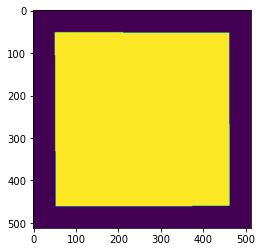

In [60]:
from src.features.cropping import get_box_mask, get_lines, pick_similar_lines

def mask_from_image(image):
    v_lines, h_lines = get_lines(image)
    
    v_lines = pick_similar_lines(v_lines[0], v_lines[1])
    h_lines = pick_similar_lines(h_lines[0], h_lines[1])
    
    return get_box_mask(image.shape, h_lines, v_lines)

plt.imshow(mask_from_image(l))

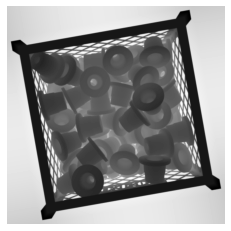

In [84]:
from skimage.transform import rotate

new_depth = rotate(depth, 10, resize=True, mode='edge')

plt.imshow(new_depth, cmap='gray')
plt.gca().set_axis_off()
plt.show()

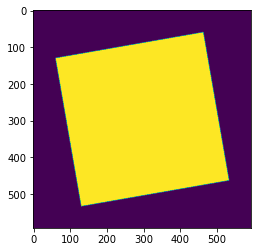

In [85]:
top = (1.5 - new_depth) >= 0.5

labeled, num = label(top, background=0, return_num=True)

l = labeled == 0

def mask_from_image(image):
    v_lines, h_lines = get_lines(image)
    
    v_lines = pick_similar_lines(v_lines[0], v_lines[1])
    h_lines = pick_similar_lines(h_lines[0], h_lines[1])
    
    return get_box_mask(image.shape, h_lines, v_lines)

plt.imshow(mask_from_image(l))

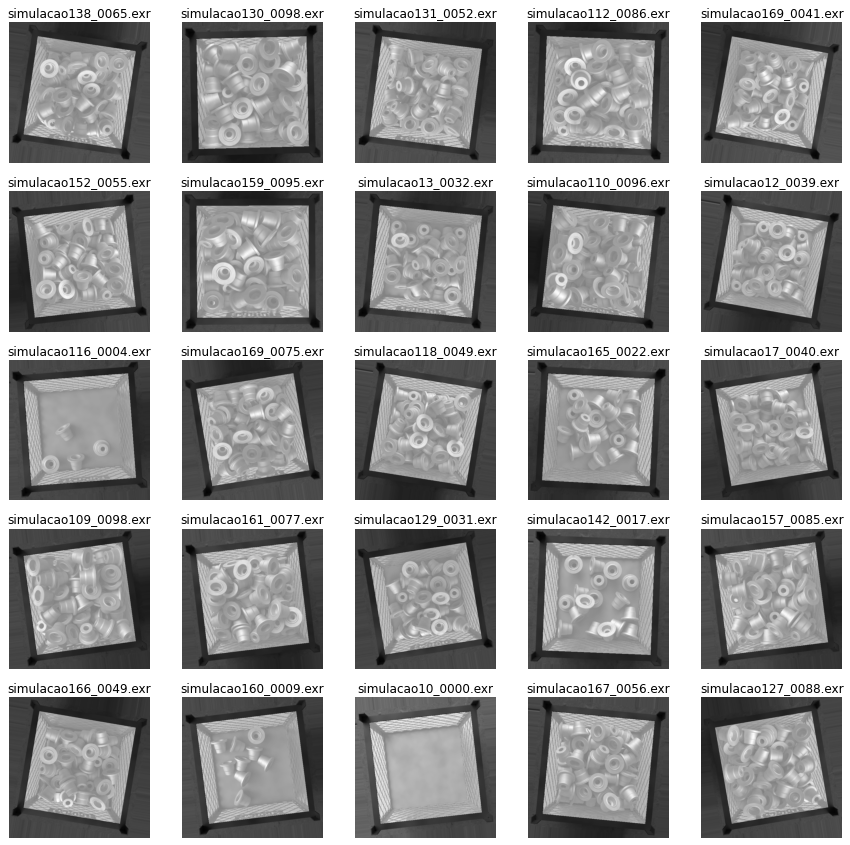

In [99]:
img_fpaths = np.random.choice(list(raw_data_dir.glob('*/*.exr')), 25, replace=False)

fig, axs = plt.subplots(5, 5)
fig.set_size_inches(15, 15)

for ax, img_fpath in zip(axs.flatten(), img_fpaths):
    rgbd = load_rgbd(img_fpath, (256,256), 711.1111)

    image = np.asarray(rgbd.color)
    depth = np.asarray(rgbd.depth)
    
    angle = 10 * 2 * (np.random.rand() - 0.5)

    depth_ = rotate(depth, angle, resize=True, mode='edge')
    image_ = rotate(image, angle, resize=True, mode='edge')

    top = (1.5-depth_) >= 0.5

    labeled, num = label(top, background=0, return_num=True)
    l = labeled == 0

    mask = mask_from_image(l)

    ax.imshow(image_, cmap='gray')
    ax.imshow(mask, cmap='gray', alpha=0.5)
    ax.set_title(img_fpath.name)

    ax.set_axis_off()

fig.show()

Everything seems alright.

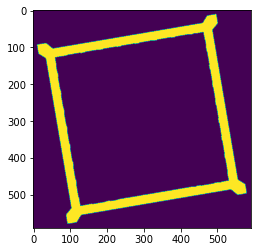

In [107]:
plt.imshow(labeled == 1)

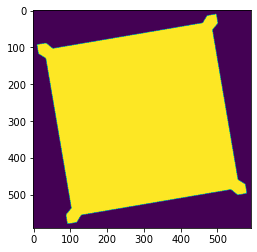

In [170]:
def fill_binary(mask):
    x, y = np.indices(mask.shape)

    x_max = np.max(x, initial=0, where=mask, axis=0)
    x_min = np.min(x, initial=mask.shape[0], where=mask, axis=0)

    y_max = np.max(y, initial=0, where=mask, axis=1)
    y_min = np.min(y, initial=mask.shape[1], where=mask, axis=1)


    return (x >= x_min) \
            & (x <= x_max) \
            & (y >= y_min.reshape((-1,1))) \
            & (y <= y_max.reshape((-1,1)))

plt.imshow(fill_binary(l))

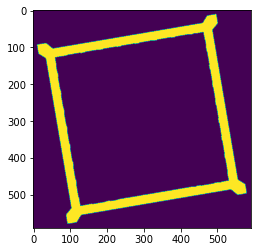

In [177]:
labels_sizes = [np.sum(fill_binary(labeled == i)) for i in range(1,num+1)]

biggest_label = np.argmax(labels_sizes) + 1

l = labeled == biggest_label
plt.imshow(l)

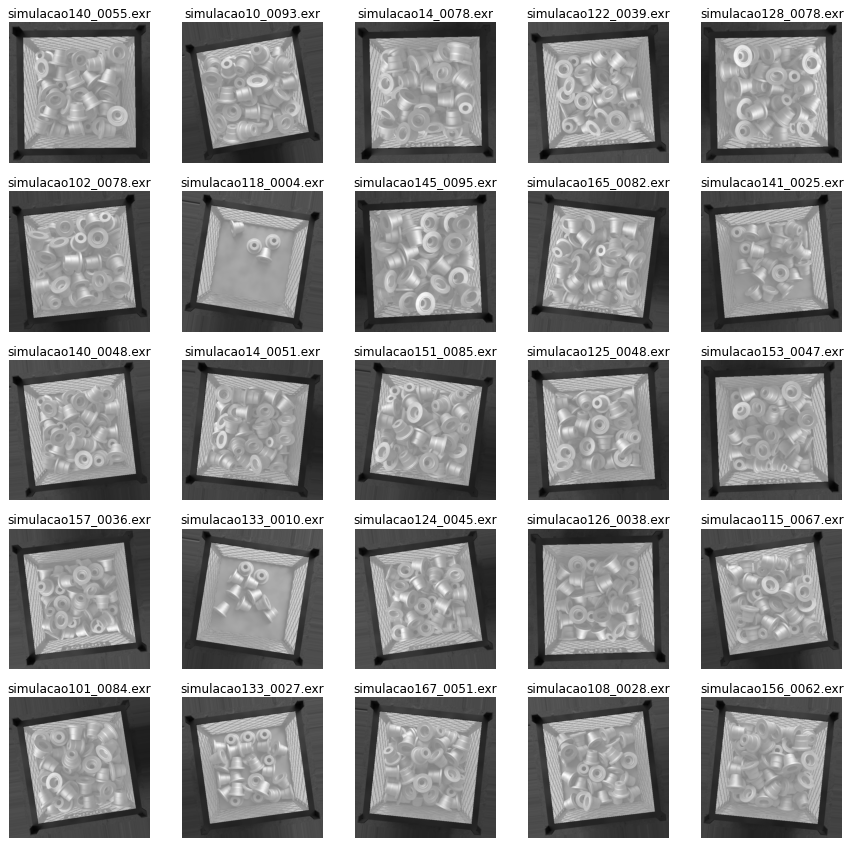

In [178]:
img_fpaths = np.random.choice(list(raw_data_dir.glob('*/*.exr')), 25, replace=False)

fig, axs = plt.subplots(5, 5)
fig.set_size_inches(15, 15)

for ax, img_fpath in zip(axs.flatten(), img_fpaths):
    rgbd = load_rgbd(img_fpath, (256,256), 711.1111)

    image = np.asarray(rgbd.color)
    depth = np.asarray(rgbd.depth)
    
    angle = 10 * 2 * (np.random.rand() - 0.5)

    depth_ = rotate(depth, angle, resize=True, mode='edge')
    image_ = rotate(image, angle, resize=True, mode='edge')

    top = (1.5-depth_) >= 0.5

    labeled, num = label(top, background=0, return_num=True)
    
    labels_sizes = [np.sum(fill_binary(labeled == i)) for i in range(1,num+1)]

    biggest_label = np.argmax(labels_sizes) + 1

    l = labeled == biggest_label

    mask = mask_from_image(l)

    ax.imshow(image_, cmap='gray')
    ax.imshow(mask, cmap='gray', alpha=0.5)
    ax.set_title(img_fpath.name)

    ax.set_axis_off()

fig.show()

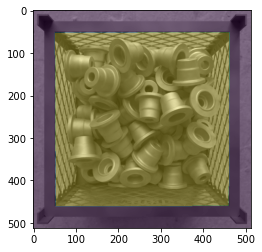

In [182]:
from src.features.cropping import box_mask_from_rgbd

rgbd = load_rgbd(img_fpath, (256,256), 711.1111)

mask = box_mask_from_rgbd(rgbd)

plt.imshow(rgbd.color, cmap='gray')
plt.imshow(mask, alpha=0.3)
plt.show()